# Grain sizes counting and distribution testing

## Preprocessing

In [58]:
import numpy as np
import matplotlib.pyplot as plt
# import ipympl
import imageio.v3 as iio
import skimage

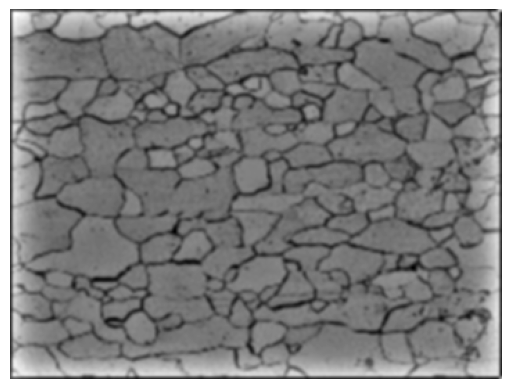

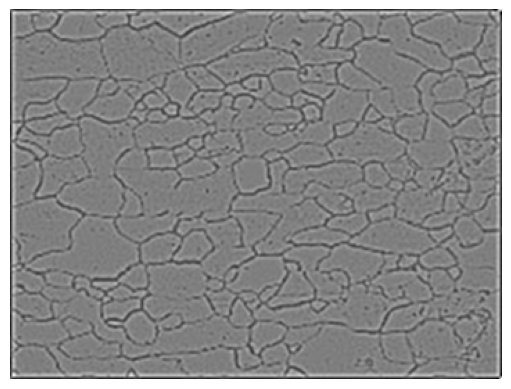

(267, 355)

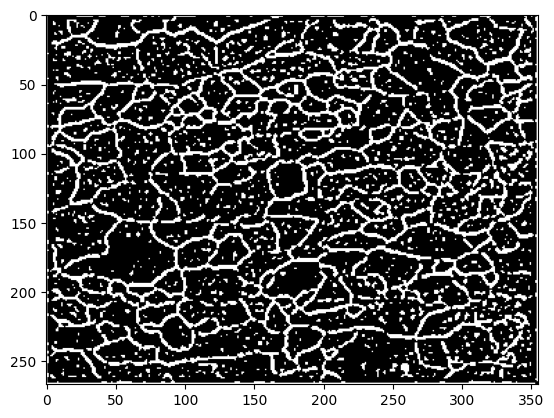

In [59]:
from skimage.filters import gaussian, median, difference_of_gaussians, laplace
from skimage.feature import canny
from skimage import exposure

image_original = iio.imread(uri="data/structure01.jpg")

# fig = plt.figure()
# fig.add_subplot(2, 2, 1)
# plt.imshow(image_original)
# # print(image)
# # image_original.shape
# gray_image = skimage.color.rgb2gray(image_original)
# fig.add_subplot(2, 2, 2)
# plt.imshow(gray_image)
# filtered_image = median(gray_image)
# fig.add_subplot(2, 2, 3)
# plt.imshow(filtered_image)
# image_canny = canny(filtered_image, 1.5)
# image = image_canny.copy()
# fig.add_subplot(2, 2, 4)
# plt.imshow(image, cmap='gray')
# plt.show(block=True)

gray_image = skimage.color.rgb2gray(image_original)
# fig, ax = plt.subplots()
# plt.axis('off')
# plt.imshow(gray_image, cmap='gray')
filtered_image = difference_of_gaussians(gray_image, 1, 12)
fig, ax = plt.subplots()
plt.axis('off')
plt.imshow(filtered_image, cmap='gray')
image_edges = laplace(filtered_image, 8)
image = image_edges.copy()
fig, ax = plt.subplots()
plt.axis('off')
plt.imshow(image, cmap='gray')
plt.autoscale(tight=True)
plt.show()

p2, p98 = np.percentile(image, (2, 98))
img_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))
img_eq = exposure.equalize_hist(image)
img_eq[img_eq>0.25] = 1
img_eq[img_eq<=0.25] = 0
img_eq = 1 - img_eq
fig, ax = plt.subplots()
plt.imshow(img_eq, cmap='gray')
image = img_eq
image.shape

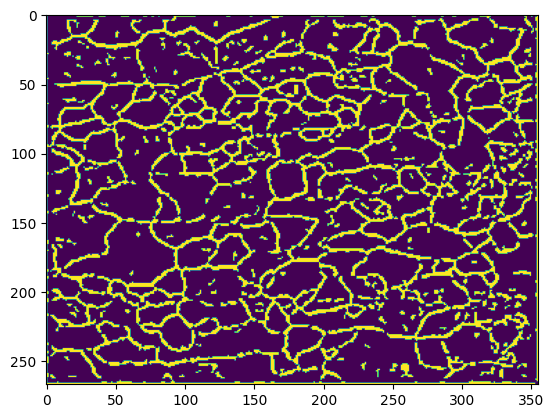

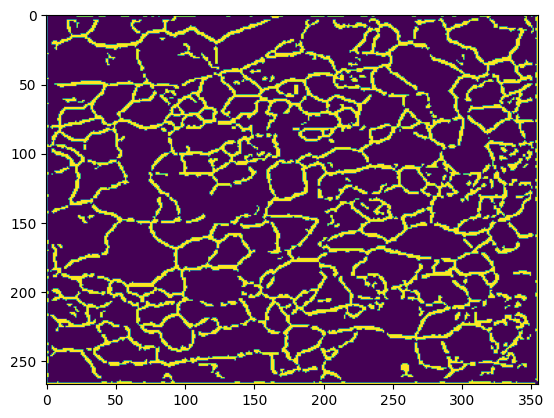

In [60]:
def remove_islands(image, kernel_size=5):
    kernel = np.zeros((kernel_size, kernel_size), np.uint8)
    kernel[:,0] = 1
    kernel[0,:] = 1
    kernel[:,-1] = 1
    kernel[-1,:] = 1
    # print(kernel)


    for i in range(0, image.shape[0]-kernel_size):
        for j in range(0, image.shape[1]-kernel_size):
            border = image[i:i+kernel_size, j:j+kernel_size]
            if((border*kernel).sum() == 0):
                image[i:i+kernel_size, j:j+kernel_size] = 0

remove_islands(image)
fig, ax = plt.subplots()
plt.imshow(image)
remove_islands(image, 10)
fig, ax = plt.subplots()
plt.imshow(image)

## Applicaion

### Grain sizes collecting

(array([57., 54., 61., 61., 69., 63., 59., 59., 50., 40., 47.,  0., 34.,
        24., 36., 30., 29., 14., 21., 14., 21., 10.,  0., 10., 12., 10.,
         4.,  8.,  9., 12.,  6.,  8.,  5.,  0.,  7.,  4.,  3.,  6.,  5.,
         3.,  4.,  1.,  3.,  1.,  0.,  6.,  2.,  4.,  4.,  2.,  0.,  0.,
         1.,  0.,  1.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  2.,  1.]),
 array([ 6.        ,  6.91025641,  7.82051282,  8.73076923,  9.64102564,
        10.55128205, 11.46153846, 12.37179487, 13.28205128, 14.19230769,
        15.1025641 , 16.01282051, 16.92307692, 17.83333333, 18.74358974,
        19.65384615, 20.56410256, 21.47435897, 22.38461538, 23.29487179,
        24.20512821, 25.11538462, 26.02564103, 26.93589744, 27.84615385,
        28.75641026, 29.66666667, 30.57692308, 31.48717949, 32.3974359 ,
        33.30769231, 34.21794872, 35.12820513, 36.03846154, 36.94871795,
        37.85897436, 38.76923077, 39.67948718, 40

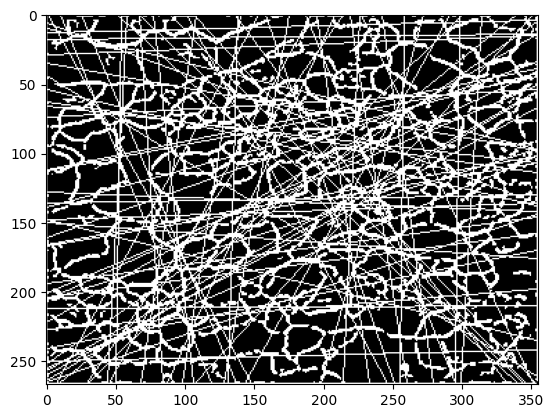

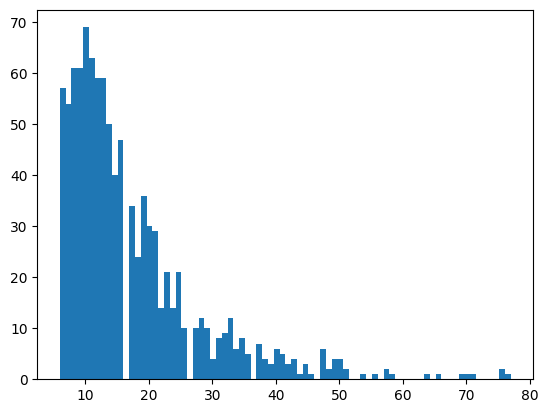

In [61]:
from skimage.draw import line
import random

def get_grains(pixels):
    peaks = pixels.copy()
    for i in range(3, len(pixels)-3):
        if not pixels[i] and pixels[i-1] and not pixels[i-2] and pixels[i+1] and not pixels[i+2]:
            peaks[i] = True
        else:
            if pixels[i] and not pixels[i-1] and pixels[i-2] and not pixels[i+1] and pixels[i+2]:
                peaks[i] = False
    peaks = np.flip(peaks)
    grains = []
    curr_len = 0
    for i in range(len(peaks)):
        if peaks[i]:
            if curr_len > 0:
                grains.append(curr_len)
            curr_len = 0
        else:
            curr_len += 1
    return grains

cuts_illustration = np.zeros(image.shape, np.uint8)
cuts_illustration = image.copy()
grains = []
desired_size = 1000
grain_border_width = 5
pseudorandomizer = np.random.RandomState(2021)
while len(grains) < desired_size:
    rand_r1 = random.randrange(image.shape[0])
    rand_c1 = random.randrange(image.shape[1])
    rand_r2 = random.randrange(image.shape[0])
    rand_c2 = random.randrange(image.shape[1])
    if pseudorandomizer.randint(0, 1000) < 500:
        rr, cc = line(rand_r1, 0, rand_r2, image.shape[1]-1)
    else:
        rr, cc = line(0, rand_c1, image.shape[0]-1, rand_c2)
    curr_line_pixels = image[rr, cc]
    cuts_illustration[rr, cc] = 1
    grain_candidates = get_grains(curr_line_pixels)
    for grain in grain_candidates:
        if grain > grain_border_width:
            grains.append(grain)

fig, ax = plt.subplots()
plt.imshow(cuts_illustration, cmap='gray')
fig, ax = plt.subplots()
grains = np.array(grains)
bins = max(grains) + 1
plt.hist(grains, density=False, bins=bins)


### Grain sizes distribution testing


Normaltest p-value is: 0.00 

We have evidence to reject the null hypothesis.


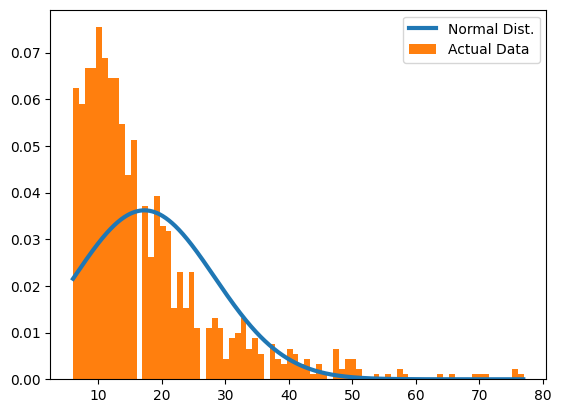

In [62]:
import scipy.stats as stats

def check_p_val(p_val, alpha):
    if p_val < alpha:
        print('We have evidence to reject the null hypothesis.')
    else:
        print('We do not have evidence to reject the null hypothesis.')

xs = np.arange(grains.min(), grains.max(), 0.1)
params = stats.norm.fit(grains)
fit = stats.norm.pdf(xs, *params)
plt.plot(xs, fit, label='Normal Dist.', lw=3)
plt.hist(grains, bins, density=True, label='Actual Data')
plt.legend()

stat, p_val = stats.normaltest(grains)
print('\nNormaltest p-value is: {:1.2f} \n'.format(p_val))
check_p_val(p_val, alpha=0.05)


KStest p-value is: 0.04 

We have evidence to reject the null hypothesis.


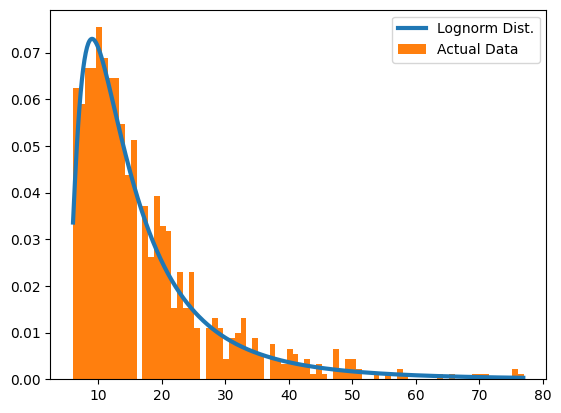

In [63]:
params = stats.lognorm.fit(grains)
fit = stats.lognorm.pdf(xs, *params)
plt.plot(xs, fit, label='Lognorm Dist.', lw=3)
plt.hist(grains, bins, density=True, label='Actual Data')
plt.legend()

stat, p_val = stats.kstest(grains, 'lognorm', args=params)
print('\nKStest p-value is: {:1.2f} \n'.format(p_val))
check_p_val(p_val, alpha=0.05)

In [64]:
import scipy.stats as st

def get_best_distribution(data):
    dist_names = ["norm", "lognorm", "gamma", "beta", "expon", "exponnorm"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

best_dist, best_p, params = get_best_distribution(grains)


p value for norm = 2.4619762595255282e-23
p value for lognorm = 0.03506344850483467
p value for gamma = 5.850725155787969e-59
p value for beta = 6.101177569910762e-10
p value for expon = 0.00018425662129761873
p value for exponnorm = 0.00011720658183392054
Best fitting distribution: lognorm
Best p value: 0.03506344850483467
Parameters for the best fit: (0.8326303539635214, 4.353605129843784, 9.289491491545657)
